In [2]:
import openfst_python as fst

**Конечные автоматы**

Конечные автоматы являются удобной структурой для работы с формальными языками и грамматикам, строковыми/текстовыми данными, а также для моделирования поведения, зависящего от контекста (состяния).

Конечный автомат описывается следующим набором объектов:

- $S, |S| < \infty$ -- конечное множество состояний автомата
- $A, |A| < \infty$ -- алфавит, множество символов, над которым действует автомат
- $E = \{ (from, to, x) | from, to \in S; x \in  A \cup \{\epsilon \} \} $ -- множество переходов, $\epsilon$ обозначает специальный "пустой" символ.
- $S_0 \subset S$ -- множество стартовых состояния. Не теряя общности, можно считать, что стартовое состояние всего одно
- $F \subset S$ -- множество финальных, или терминальных, состояний.

По сути, конечный автомат можно задавать конечным ориентированным графом, каждая дуга которого помечается символом  (возможно, пустым). В дополнение к этому на графе выделяются стартовые и терминальные вершины. Множества этих вершин могут соотносится как угодно: пересекаться, совпадать...

Далее также будет использовать понятие языка $L$ как некоторого множества строк, состоящих из букв алфавита $A$
В языке могут быть и пустые строки

Сам по себе конечный автомат умеет лишь определять: принадлежит ли поданная на вход строка $s$ языку $L$, для которого этот автомат и построен.


*Пример.* Пусть $A = \{a,b\}$ и $L$ состоит из всех строк, оканчивающихся символом $b$.
Тогда автомат, распознающий язык $L$, может иметь вид:

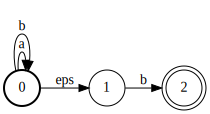

In [42]:
# openfst работает с числовыми обозначениями символов
# для отрисовки понадобится таблица соответствия                        
syms = fst.SymbolTable()
eps = syms.add_symbol("eps") #пустой символ
a = syms.add_symbol("a")
b = syms.add_symbol("b")


def arc(next_state, symbol) -> fst.Arc : 
    return fst.Arc(symbol, symbol, fst.Weight.One("tropical"), next_state)

f = fst.Fst()
f.set_input_symbols(syms)

start = f.add_state()
before_last_b = f.add_state()
final = f.add_state()
f.add_arc(start, arc(before_last_b, eps))
f.add_arc(before_last_b, arc(final, b))
f.add_arc(start, arc(start, a))
f.add_arc(start, arc(start, b))
f.set_start(start)
f.set_final(final)

**Как работает автомат?**

В начальный момен времени автомат находится во множестве стартовых состояний. Для примера выше -- это вершина 0.
На вход автомату подается строка $s$, которая обрабатывается посимвольно.
Обрабатывая символы, автомат переходит из одного множества состояний в другое. По окончании работы автомат оказывается во множестве состояний $C$. Если $C \cap F = \emptyset$ строка не принадлежит языку. Иначе -- принадлежит.


In [54]:
# добавить во множество состояний все состояния, достижимые из него по eps-переходам
def eps_closure(fsa, states_set):
    from collections import deque
    
    Q = deque()
    visited = set(states_set)
    Q.extend(list(states_set))
    
    while Q:
        s = Q.popleft()
        for arc in f.arcs(s):
            if arc.ilabel != 0: 
                continue
            if arc.nextstate not in visited:
                visited |= {arc.nextstate}
                Q.append(arc.nextstate)
        
    
    return visited

# перейти в новое множество состояний по метке label
def advance(fsa, states_set, label):
    new_states_set = set()
    for s in states_set:
        for arc in f.arcs(s):
            if arc.ilabel == label:
                new_states_set |= {arc.nextstate}
    return new_states_set
                 

*Алгоритм работы автомата*

In [71]:
def is_final(fsa, state) -> bool :
    #специфика openfst
    return fsa.final(state) != fst.Weight.Zero("tropical")

#принадлежит или не пренадлежит строка s языку автомата?
def check(fsa, s) -> bool : 
    symbols = f.input_symbols()
    states = { fsa.start() }
    for x in s :
        states = eps_closure(fsa, states)
        states = advance(fsa, states, symbols.find(x))
    states = eps_closure(fsa, states)
    
    for end_state in states:
        if is_final(fsa, end_state):
            return True
        
    return False

*Примеры*


In [69]:
check(f, "aab")

True

In [70]:
check(f, "aba")

False

**Детерминированные и недетерминированные автоматы**

При описании того, что такое конечный автомат, мы определили, вообще говоря, недетерминированный автомат (НКА). То есть в некоторые моменты времени он может находиться не в одном конкретном состоянии, а сразу во множестве состояний.

Можно наложить дополнительные ограничения на автомат
1. Ровно одно начальное состояние 
2. Отсутствие $\epsilon$-переходов
3. Из любой вершины $s$ по одному и тому же символу может выходить не более одной дуги

Автомат, удовлетворяющий этим ограничениям, является детерминированным (ДКА).

Автомат из примера выше, как можно заметить по процессу обработки строк, не является детерминированным. У него как минимум есть $\epsilon$-переход. От него можно избавиться, удалив промежуточное состояние

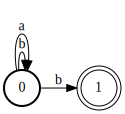

In [87]:
f.rmepsilon()
f

У полученного автомата уже нет $\epsilon$-переходов, но он все равно остается недетерминированным: после перехода по символу $b$ он будет находиться одновременно в двух состояниях.

Для конечных автоматов справедлива замечательная теорема:

*Для любого НКА существует эквивалентный ему ДКА. Эквивалентность понимается в том смысле, что они распознают один и тот же язык*

Иначего говоря, любой НКА можно детерминизировать: можно построить автомат, множеством состояний которого будет булеан $2^S$, и провести в нем все возможные переходы, возникающие на шаге 3 алгоритма работы исходного автомата. [подробнее](https://en.wikipedia.org/wiki/Powerset_construction)


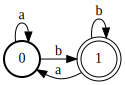

In [88]:
f = fst.determinize(f)
f

Поведение детерминизированного автомата осталось таким же:

In [89]:
check(f, "aab")

True

In [90]:
check(f, "aba")

False

Однако алгоритм работы для детерминированного автомата проще

In [93]:
# перейти в новое множество состояний по метке label
def advance_determinized(fsa, state, label):
    if state is None:
        return None
    
    for arc in f.arcs(state):
        if arc.ilabel == label:
            return arc.nextstate
    return None

#принадлежит или не пренадлежит строка s языку автомата?
def check_determinized(fsa, s) -> bool : 
    symbols = f.input_symbols()
    state = fsa.start()
    for x in s :
        state = advance_determinized(fsa, state, symbols.find(x))
    return state is not None and is_final(fsa, state)

In [94]:
check_determinized(f, "aab")

True

In [95]:
check_determinized(f, "aba")

False